In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from lightgbm import plot_tree

RANDOM_STATE = 42

In [32]:
df = pd.read_csv('encoded_categorical_features.csv')

In [33]:
df.shape

(2927, 117)

In [34]:
df.dtypes.value_counts()

int64      62
bool       38
float64    17
Name: count, dtype: int64

We will be working with the version of the df where all missing values where handled and all categorical features where converted to numerical ones.

In [35]:
df['SalePrice_binned'] = pd.qcut(df['SalePrice'], q=5, labels=False)
df['SalePrice_binned'].value_counts()

SalePrice_binned
0    595
3    593
2    581
1    580
4    578
Name: count, dtype: int64

The continous SalesPrice target variable was discretisised into 5 classes.

In [36]:
X = df.drop(columns=['SalePrice', 'SalePrice_binned'])
Y = df['SalePrice_binned']

In [37]:
X.shape, Y.shape

((2927, 116), (2927,))

First, no stratification

In [38]:
'''80-20 unstratified k-fold cross validation with lightgbm classifier'''
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=RANDOM_STATE
)

In [39]:
lgb80_20 = lgb.LGBMClassifier(
    n_estimators=3,           # Number of boosting iterations - good default to start
    learning_rate=0.1,          # Controls how much we adjust weights - 0.1 is a good default
    max_depth=3,               # No limit on tree depth for better accuracy
    num_leaves=31,              # Maximum number of leaves in one tree
    min_child_samples=20,       # Minimum samples per leaf to prevent overfitting
    colsample_bytree=0.8,       # Fraction of features used per tree - helps prevent overfitting
    subsample=0.8,              # Fraction of samples used for training each tree
    random_state=RANDOM_STATE
)

In [40]:
lgb80_20.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3778
[LightGBM] [Info] Number of data points in the train set: 2341, number of used features: 110
[LightGBM] [Info] Start training from score -1.595019
[LightGBM] [Info] Start training from score -1.629283
[LightGBM] [Info] Start training from score -1.612004
[LightGBM] [Info] Start training from score -1.599238
[LightGBM] [Info] Start training from score -1.612004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.1
,n_estimators,3
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [41]:
y_pred80_20 = lgb80_20.predict(X_test)
y_pred80_20_proba = lgb80_20.predict_proba(X_test)
y_pred80_20
y_pred80_20_proba

array([[0.13725017, 0.13270014, 0.13740723, 0.18119891, 0.41144354],
       [0.21690384, 0.27812194, 0.19169431, 0.15693213, 0.15634777],
       [0.15321248, 0.14813328, 0.24759137, 0.29824207, 0.1528208 ],
       ...,
       [0.14253981, 0.13781442, 0.14270292, 0.14964222, 0.42730062],
       [0.16203821, 0.15666642, 0.19767879, 0.27259133, 0.21102526],
       [0.24759525, 0.25465319, 0.21090715, 0.14368974, 0.14315468]],
      shape=(586, 5))

In [42]:
acc = accuracy_score(y_test, y_pred80_20)
print(f'Accuracy: {acc:.4f}')

print('Classification Report:\n', classification_report(y_test, y_pred80_20))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred80_20))


Accuracy: 0.6775
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.75       120
           1       0.51      0.61      0.56       121
           2       0.52      0.38      0.44       114
           3       0.70      0.76      0.73       120
           4       0.88      0.90      0.89       111

    accuracy                           0.68       586
   macro avg       0.68      0.68      0.67       586
weighted avg       0.67      0.68      0.67       586


Confusion Matrix:
 [[ 89  27   3   0   1]
 [ 22  74  21   3   1]
 [  4  40  43  27   0]
 [  1   3  14  91  11]
 [  0   0   2   9 100]]


<Figure size 8000x4000 with 0 Axes>

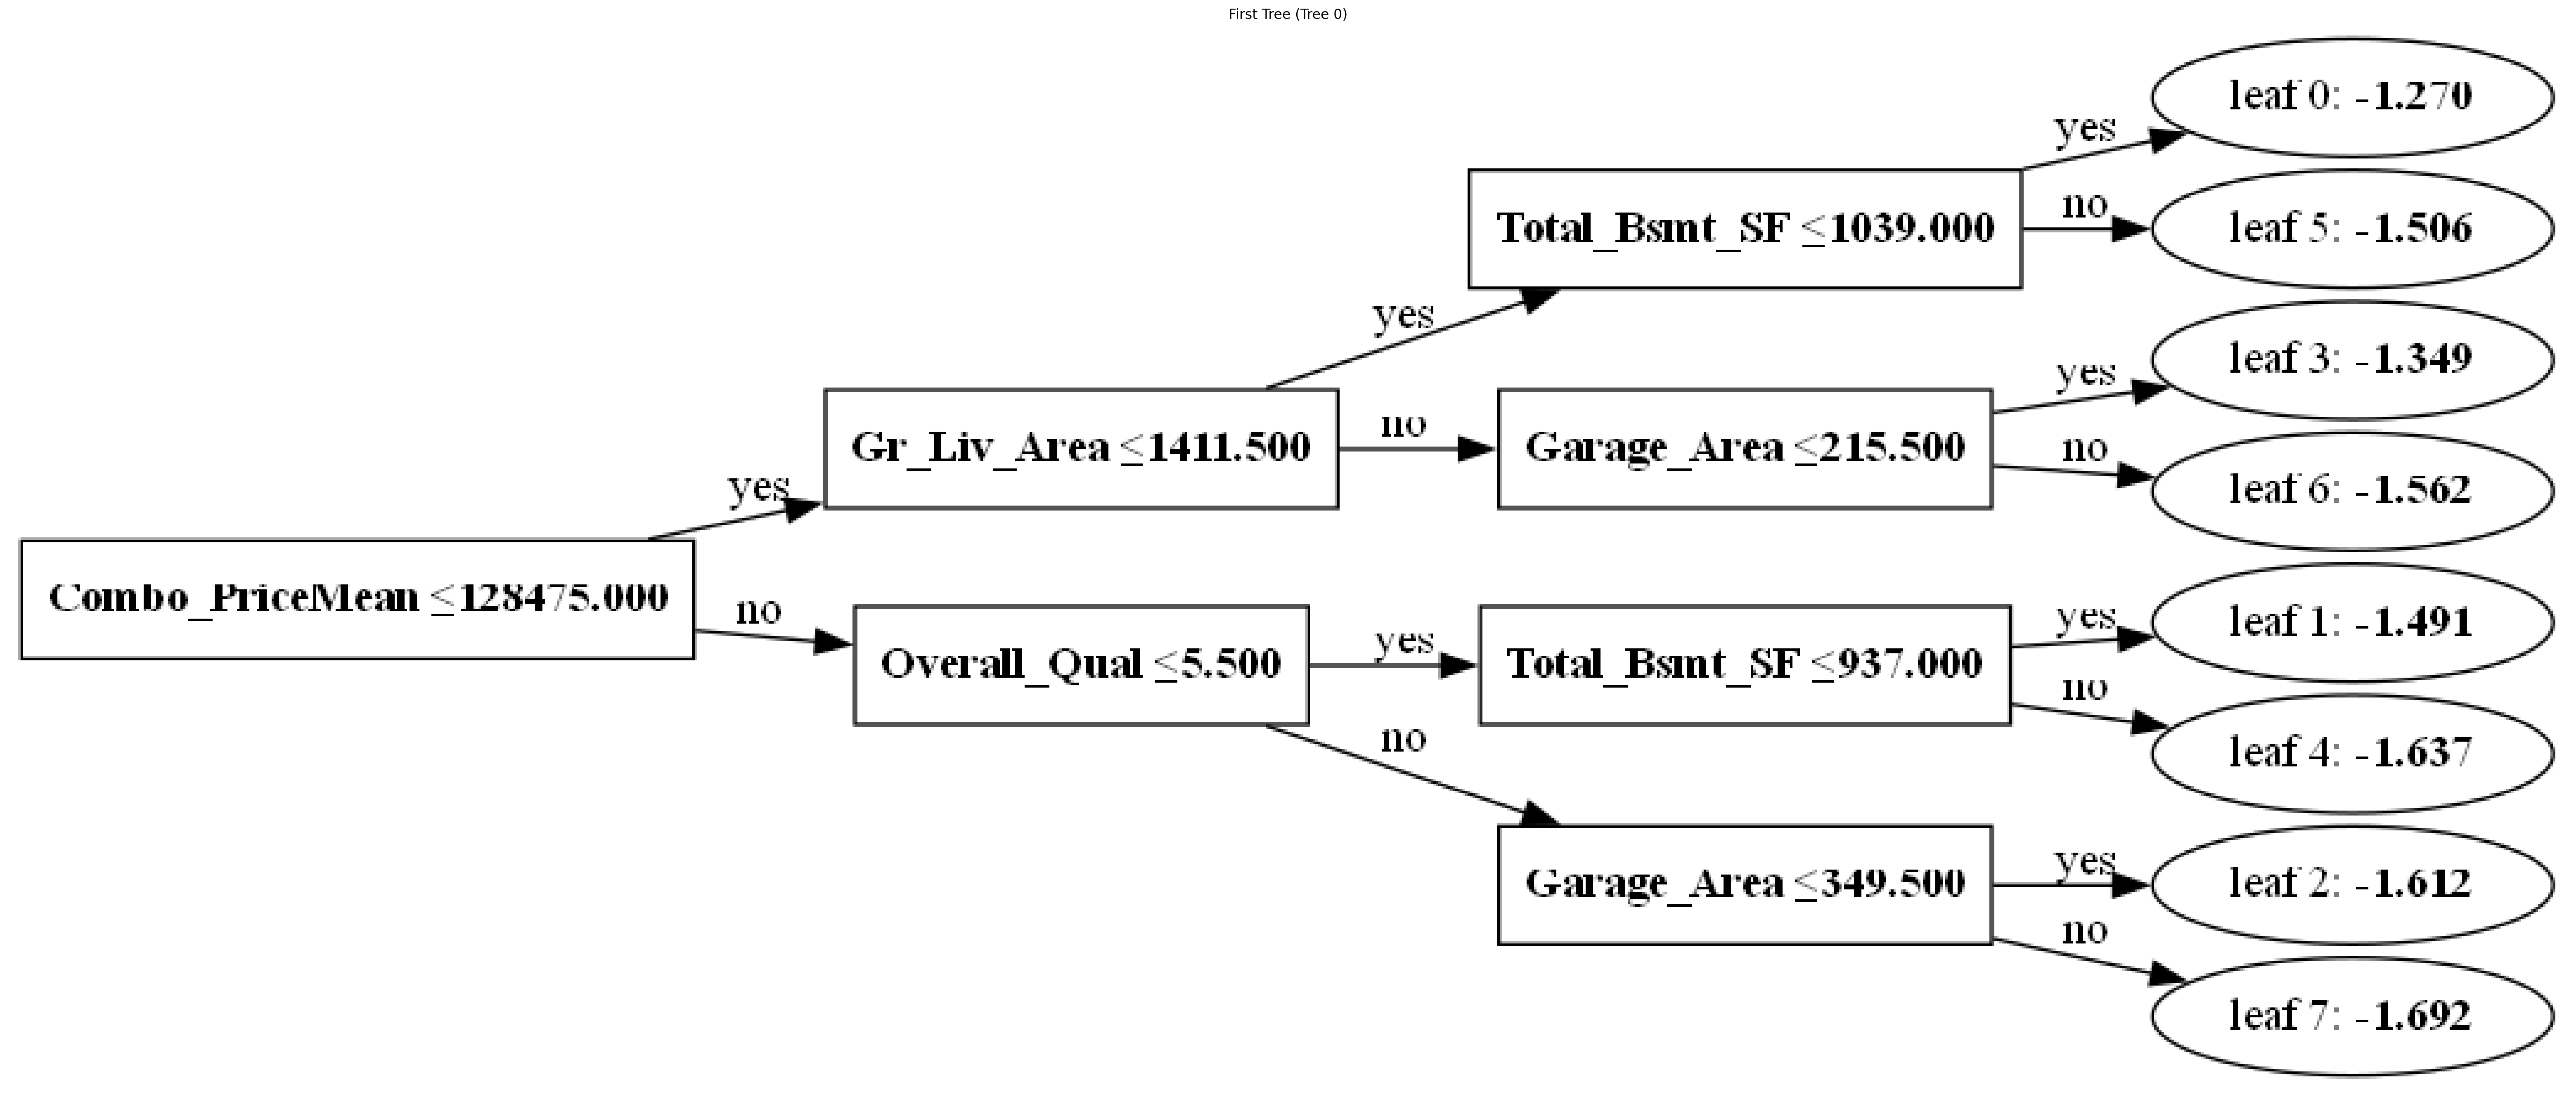

In [43]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(lgb80_20, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()


<Figure size 2000x1000 with 0 Axes>

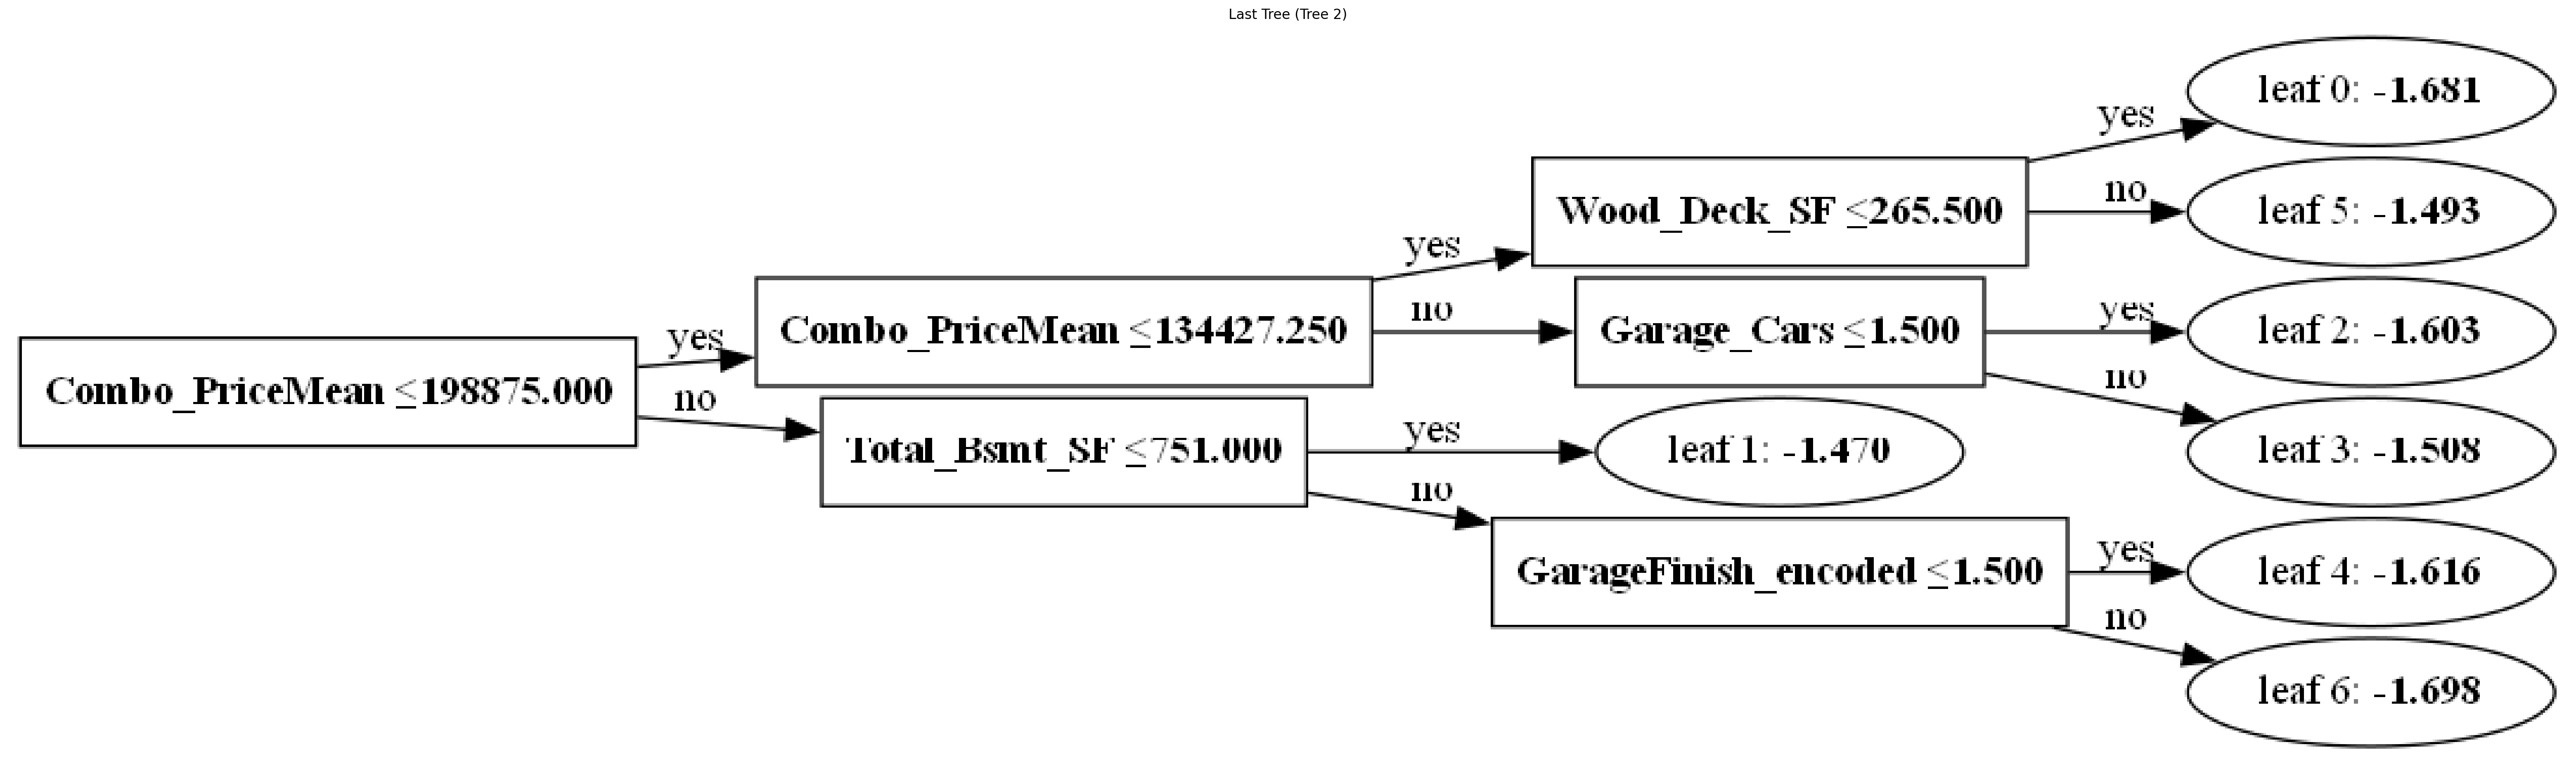

In [45]:
# last tree = index num_estimators - 1
last_tree_idx = lgb80_20.n_estimators - 1
plt.figure(figsize=(20, 10))
plot_tree(lgb80_20, tree_index=last_tree_idx, figsize=(40, 20), dpi=200)
plt.title(f"Last Tree (Tree {last_tree_idx})")
plt.show()

And now the same for 10-90 split.

In [46]:
'''90-10 unstratified k-fold cross validation with lightgbm classifier'''
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=RANDOM_STATE
)

In [47]:
lgb80_20 = lgb.LGBMClassifier(
    n_estimators=3,           # Number of boosting iterations - good default to start
    learning_rate=0.1,          # Controls how much we adjust weights - 0.1 is a good default
    max_depth=3,               # No limit on tree depth for better accuracy
    num_leaves=31,              # Maximum number of leaves in one tree
    min_child_samples=20,       # Minimum samples per leaf to prevent overfitting
    colsample_bytree=0.8,       # Fraction of features used per tree - helps prevent overfitting
    subsample=0.8,              # Fraction of samples used for training each tree
    random_state=RANDOM_STATE
)

In [48]:
lgb80_20.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3826
[LightGBM] [Info] Number of data points in the train set: 2634, number of used features: 110
[LightGBM] [Info] Start training from score -1.582840
[LightGBM] [Info] Start training from score -1.634036
[LightGBM] [Info] Start training from score -1.609058
[LightGBM] [Info] Start training from score -1.605270
[LightGBM] [Info] Start training from score -1.616677
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.1
,n_estimators,3
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [49]:
y_pred80_20 = lgb80_20.predict(X_test)
y_pred80_20_proba = lgb80_20.predict_proba(X_test)
y_pred80_20
y_pred80_20_proba

array([[0.13916042, 0.13210328, 0.13771495, 0.18170522, 0.40931613],
       [0.24823787, 0.27797472, 0.16426137, 0.15492651, 0.15459952],
       [0.15398986, 0.14618069, 0.25341921, 0.29481362, 0.15159661],
       ...,
       [0.14185088, 0.1346573 , 0.14037746, 0.2113545 , 0.37175986],
       [0.15398986, 0.14618069, 0.25341921, 0.29481362, 0.15159661],
       [0.29290222, 0.23671078, 0.18466521, 0.14301182, 0.14270997]],
      shape=(293, 5))

In [50]:
acc = accuracy_score(y_test, y_pred80_20)
print(f'Accuracy: {acc:.4f}')

print('Classification Report:\n', classification_report(y_test, y_pred80_20))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred80_20))


Accuracy: 0.6724
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.85      0.76        54
           1       0.60      0.55      0.57        66
           2       0.45      0.37      0.41        54
           3       0.69      0.77      0.73        64
           4       0.90      0.84      0.87        55

    accuracy                           0.67       293
   macro avg       0.67      0.67      0.67       293
weighted avg       0.67      0.67      0.67       293


Confusion Matrix:
 [[46  7  1  0  0]
 [15 36 14  1  0]
 [ 6 15 20 13  0]
 [ 0  2  8 49  5]
 [ 0  0  1  8 46]]


<Figure size 8000x4000 with 0 Axes>

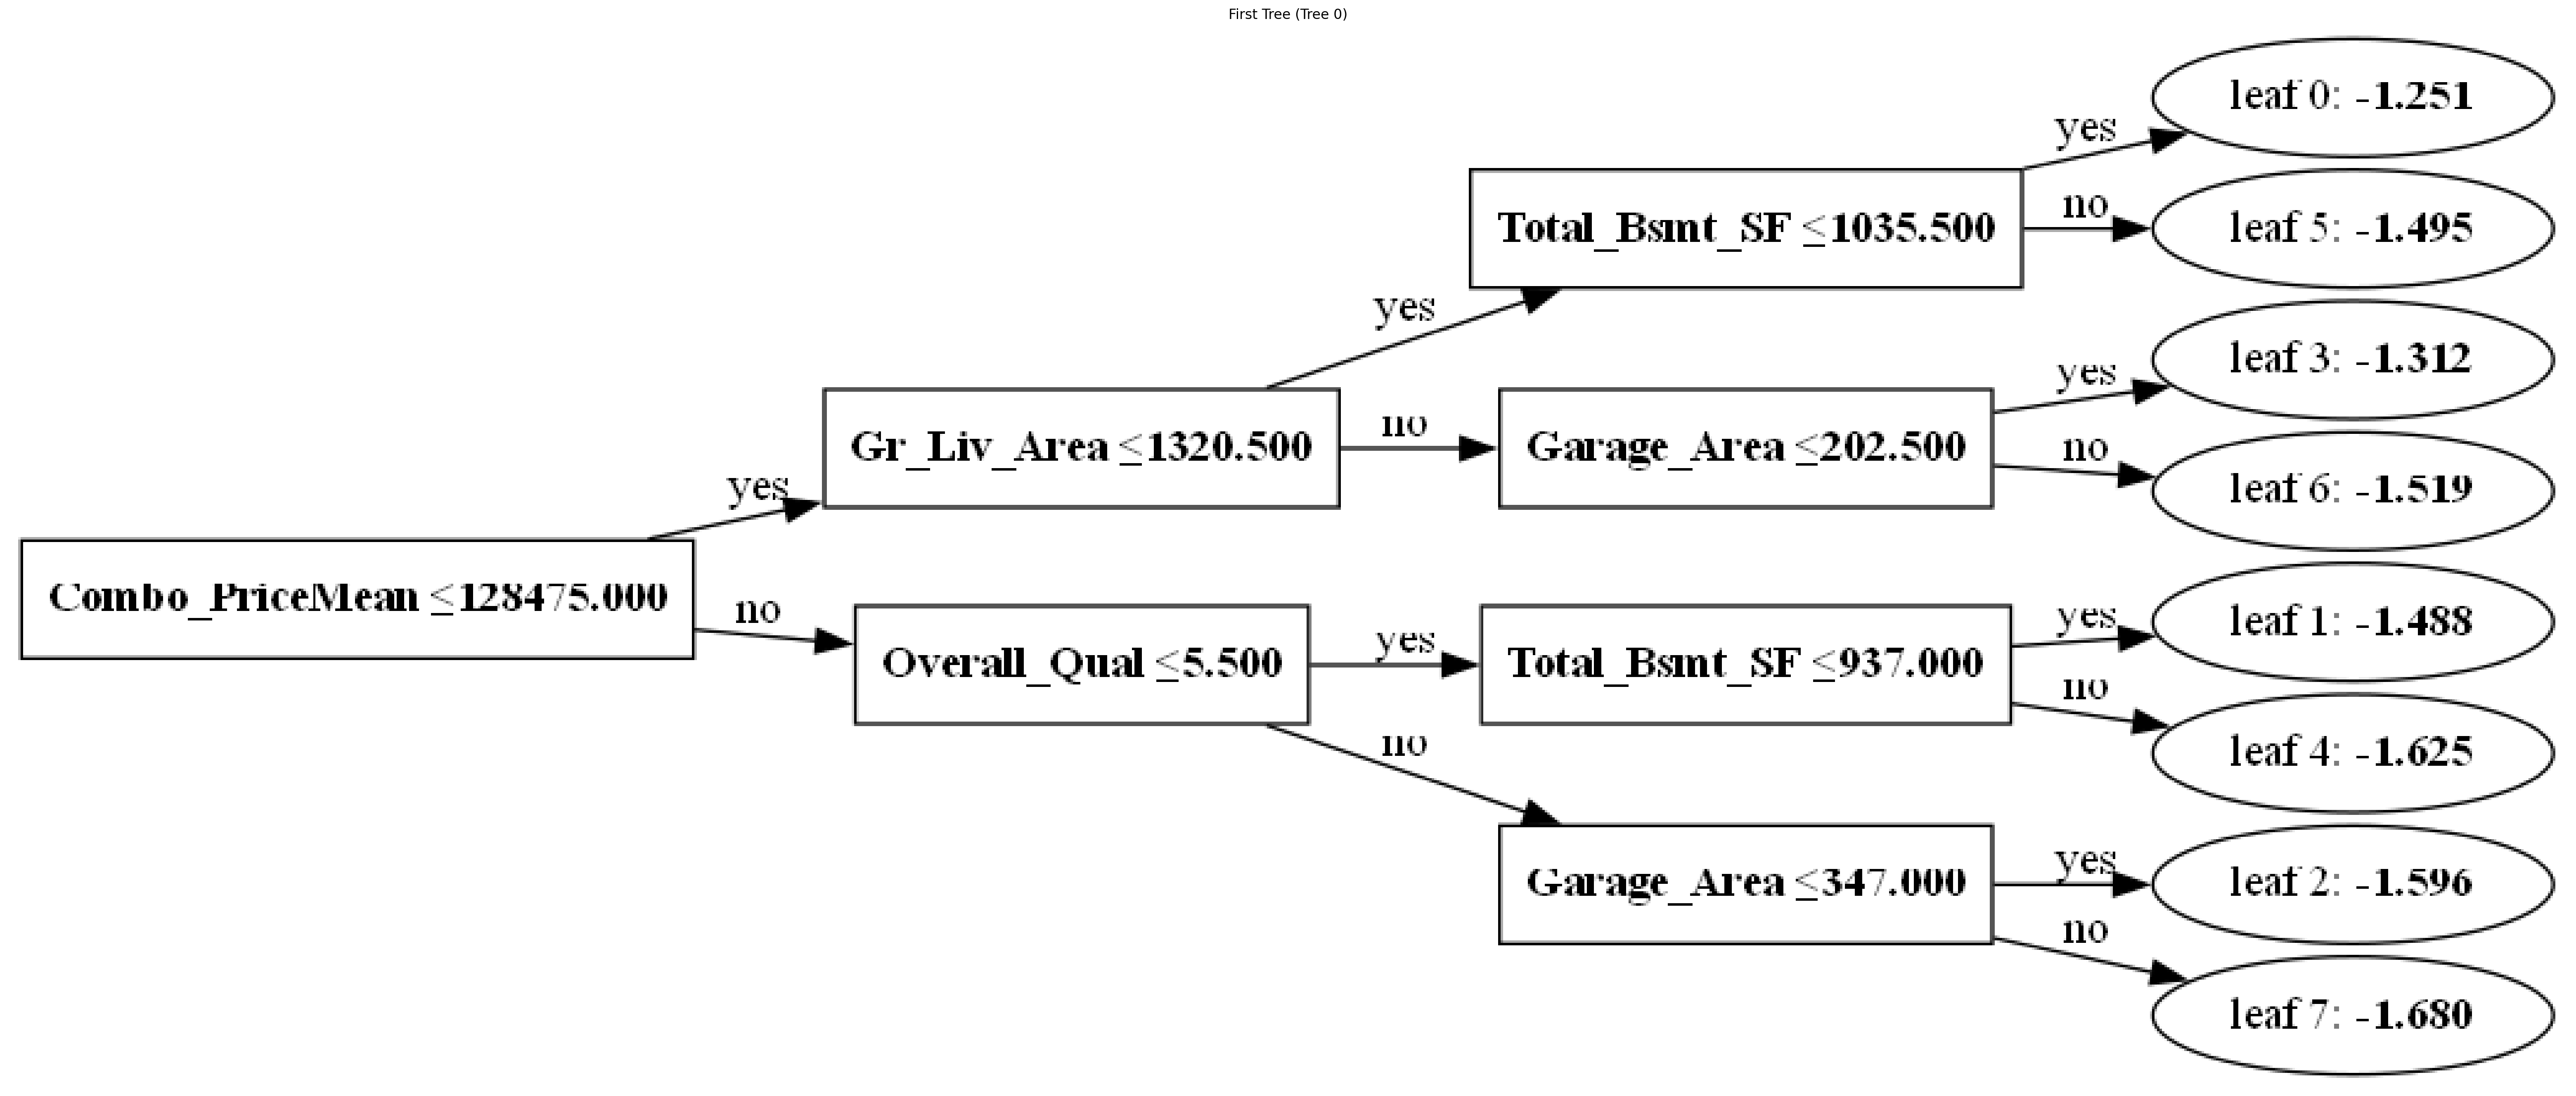

In [51]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(lgb80_20, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()


<Figure size 8000x4000 with 0 Axes>

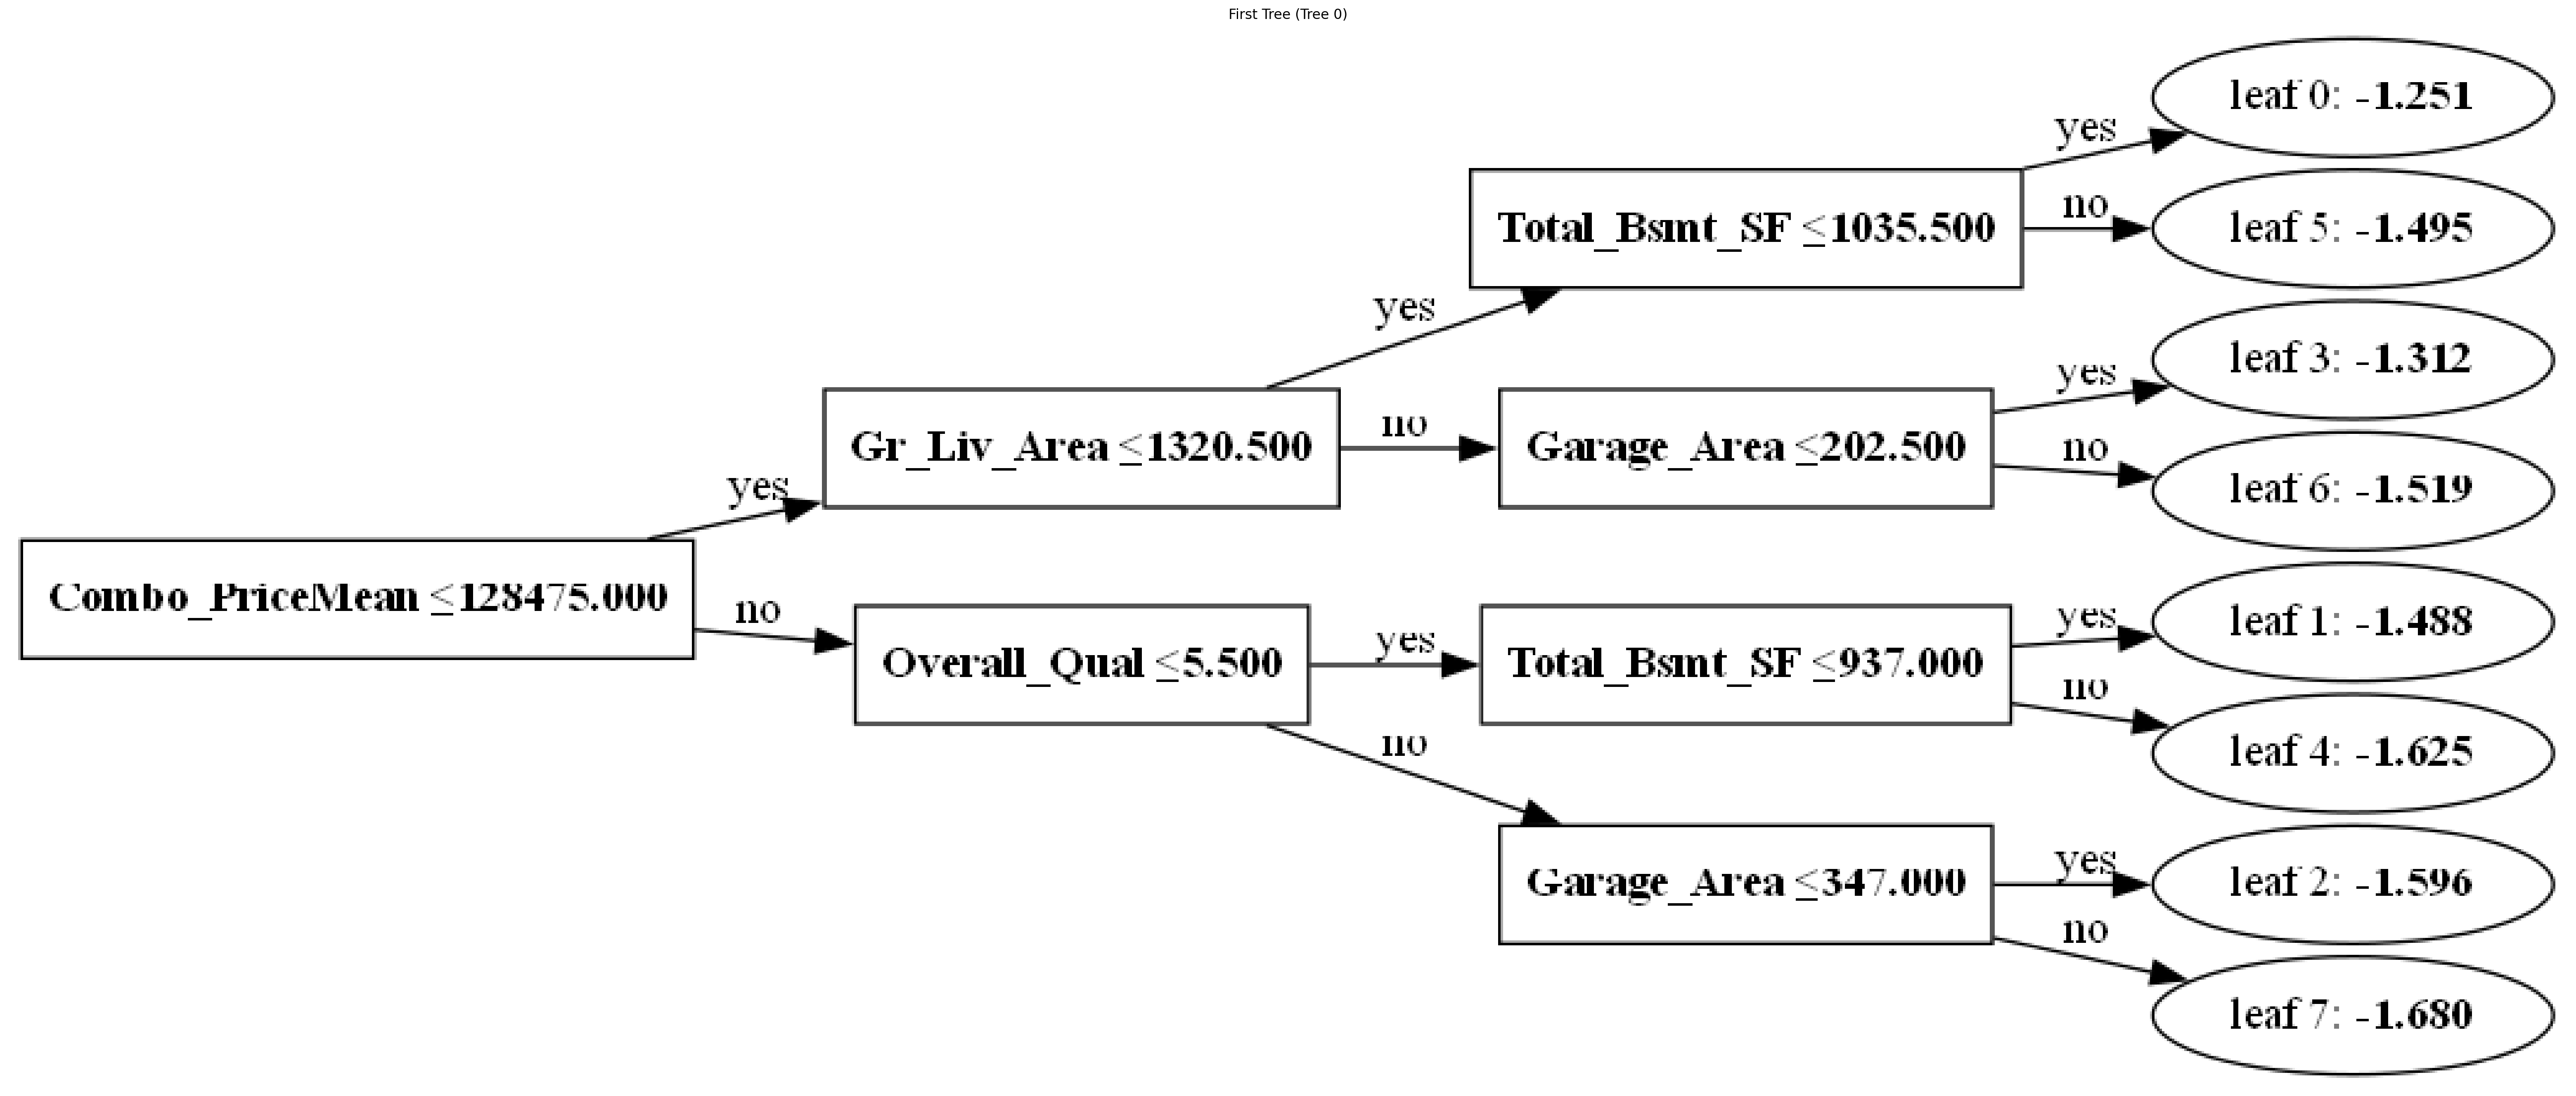

In [52]:
'''Plot of the first and last tree'''
# first tree = index 0
plt.figure(figsize=(40, 20), dpi=200)
plot_tree(lgb80_20, tree_index=0, figsize=(40, 20), dpi=200)
plt.title("First Tree (Tree 0)")
plt.show()
